In [2]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [3]:
from core.quantum_error_correction_code import SurfaceCode
from core.neural_network import CNNDual, load_params

from core.environment import EnvironmentPML

import jax.numpy as jnp
from jax import random
from time import time
import matplotlib.pyplot as plt

key = random.key(32)

In [18]:
decoder_type = "CNN-G" # CNN-G or CNN-P
settings, model_params = load_params(f"data/{decoder_type}-3.json")
print(settings.keys())

dict_keys(['TRAINING_BATCHES', 'BATCH_SIZE', 'SEED', 'INIT_LEARNING_RATE', 'LEARNING_RATE', 'WARMUP_STEPS', 'TRANSITION_STEP', 'DECAY_RATE', 'CODE_DISTANCE', 'ERROR_PROBS', 'CONV_LAYERS_INPUT_1', 'CONV_LAYERS_INPUT_2', 'CONV_LAYERS_STAGE_2', 'FC_LAYERS'])


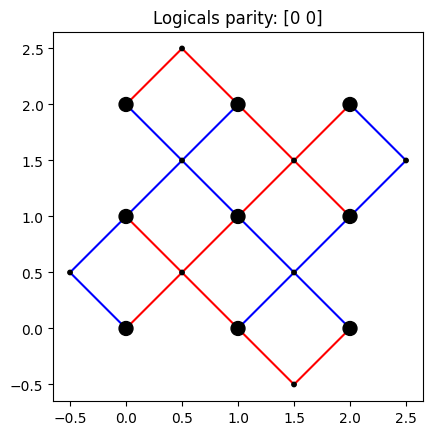

In [6]:
code = SurfaceCode(settings["CODE_DISTANCE"])
parity_info = code.deformation_parity_info(jnp.zeros(code.num_data_qubits, dtype=jnp.int32))
code.show(parity_info)

In [7]:
env = EnvironmentPML(
    noise_model=settings["ERROR_PROBS"],
    code=code,
)

In [9]:
env._get_state_error_rate(key, jnp.array([3, 2, 1, 2, 2, 3, 2, 0, 2]))[0]

Array(2.4914742e-05, dtype=float32)

In [10]:
state, score, key = env.reset(key)
score

Array(5.8191786, dtype=float32)

In [11]:
time_limit = 10
sample_count = 0
t0 = time()
while time() - t0 < time_limit:
    state, score, key = env.reset(key)
    sample_count = sample_count + 1
print(f"Average execution time = {(time()-t0)/sample_count:.3f}s per exact estimate ({sample_count} samples)")

Average execution time = 0.001s per exact estimate (9630 samples)


In [12]:
scores = []
for i in range(100):
    state, score, key = env.reset(key)
    scores.append(score)

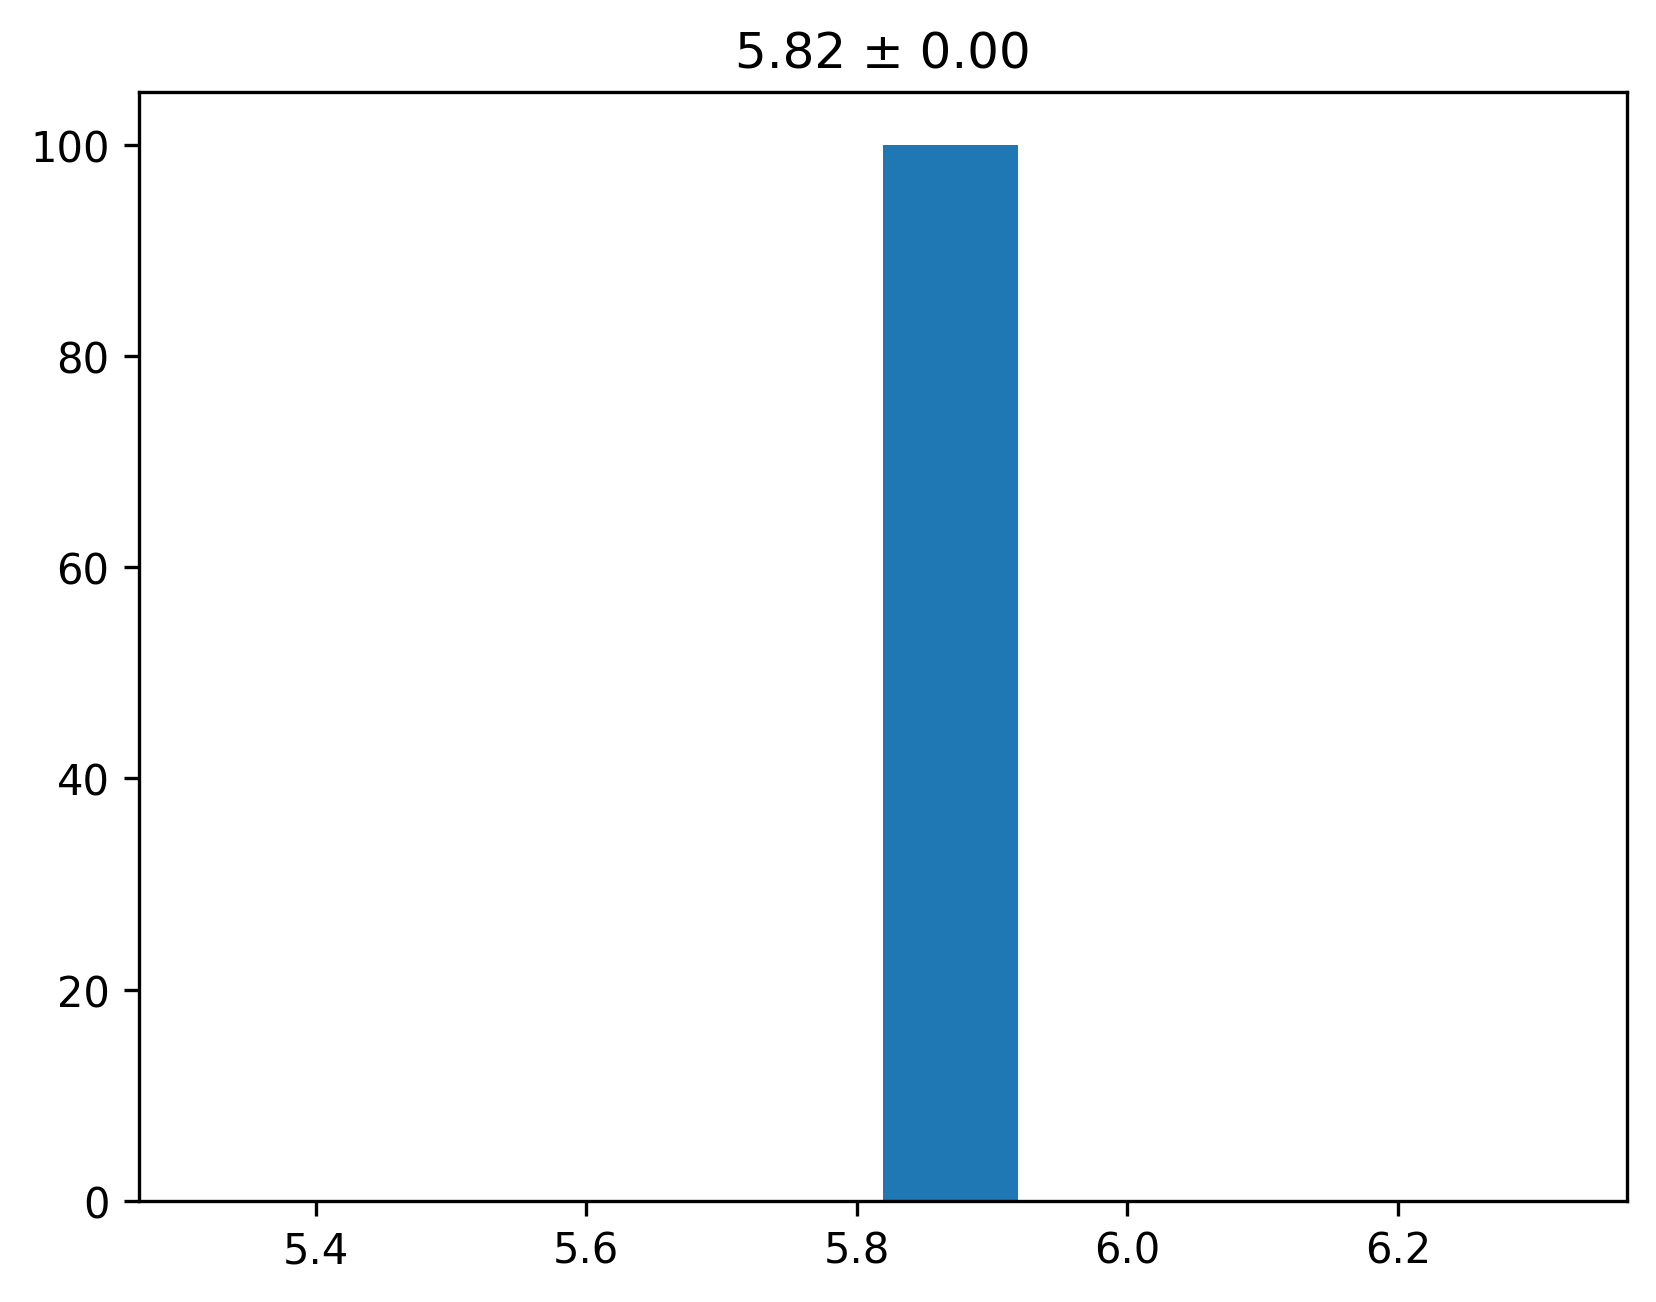

In [13]:
x = jnp.array(scores)

plt.figure(dpi=300)
plt.title(f"{x.mean():.2f} ± {x.std():.2f}")
plt.hist(x)
plt.show()

# Make graph

In [14]:
deformations_included = jnp.array([0,2,3])
m = deformations_included.shape[0] # Number of diferent deformations per qubit
n = code.hx_original.shape[1] # Number of data qubits that can have deformations
all_deformations = jnp.zeros(shape=(m**n, n), dtype=jnp.int32) + jnp.arange(0, m**n)[:, None]
all_deformations = (all_deformations // m**jnp.arange(0, n)) % m
all_deformations = deformations_included[all_deformations]
print(all_deformations.shape)
print(all_deformations)

(19683, 9)
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [0 3 3 ... 3 3 3]
 [2 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [15]:
from jax import vmap
from time import time
t0 = time()

all_logical_error_rates = jnp.zeros(all_deformations.shape[0])
batch_size = m**3
for i, deformations_batch in enumerate(all_deformations.reshape((-1, batch_size, n))):
    all_logical_error_rates = all_logical_error_rates.at[i*batch_size:(i+1)*batch_size].set(
        vmap(env._get_state_error_rate, in_axes=(None, 0))(key, deformations_batch)[0]
    )
    procentage = (i+1) / (all_deformations.shape[0] // batch_size)
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s    ({procentage:.2%})"+10*" ", end='\r')
total_time = time()-t0
print(f"Total time used = {int(total_time/60/60):5d}h {int(total_time/60%60):02d}m {int(total_time%60):02d}s"+50*" ", end='\r')
jnp.save("data/environmentPML_error_rates_p01_nu500.npy", all_logical_error_rates)

In [16]:
all_logical_error_rates = jnp.load("data/environmentPML_error_rates_p01_nu500.npy")

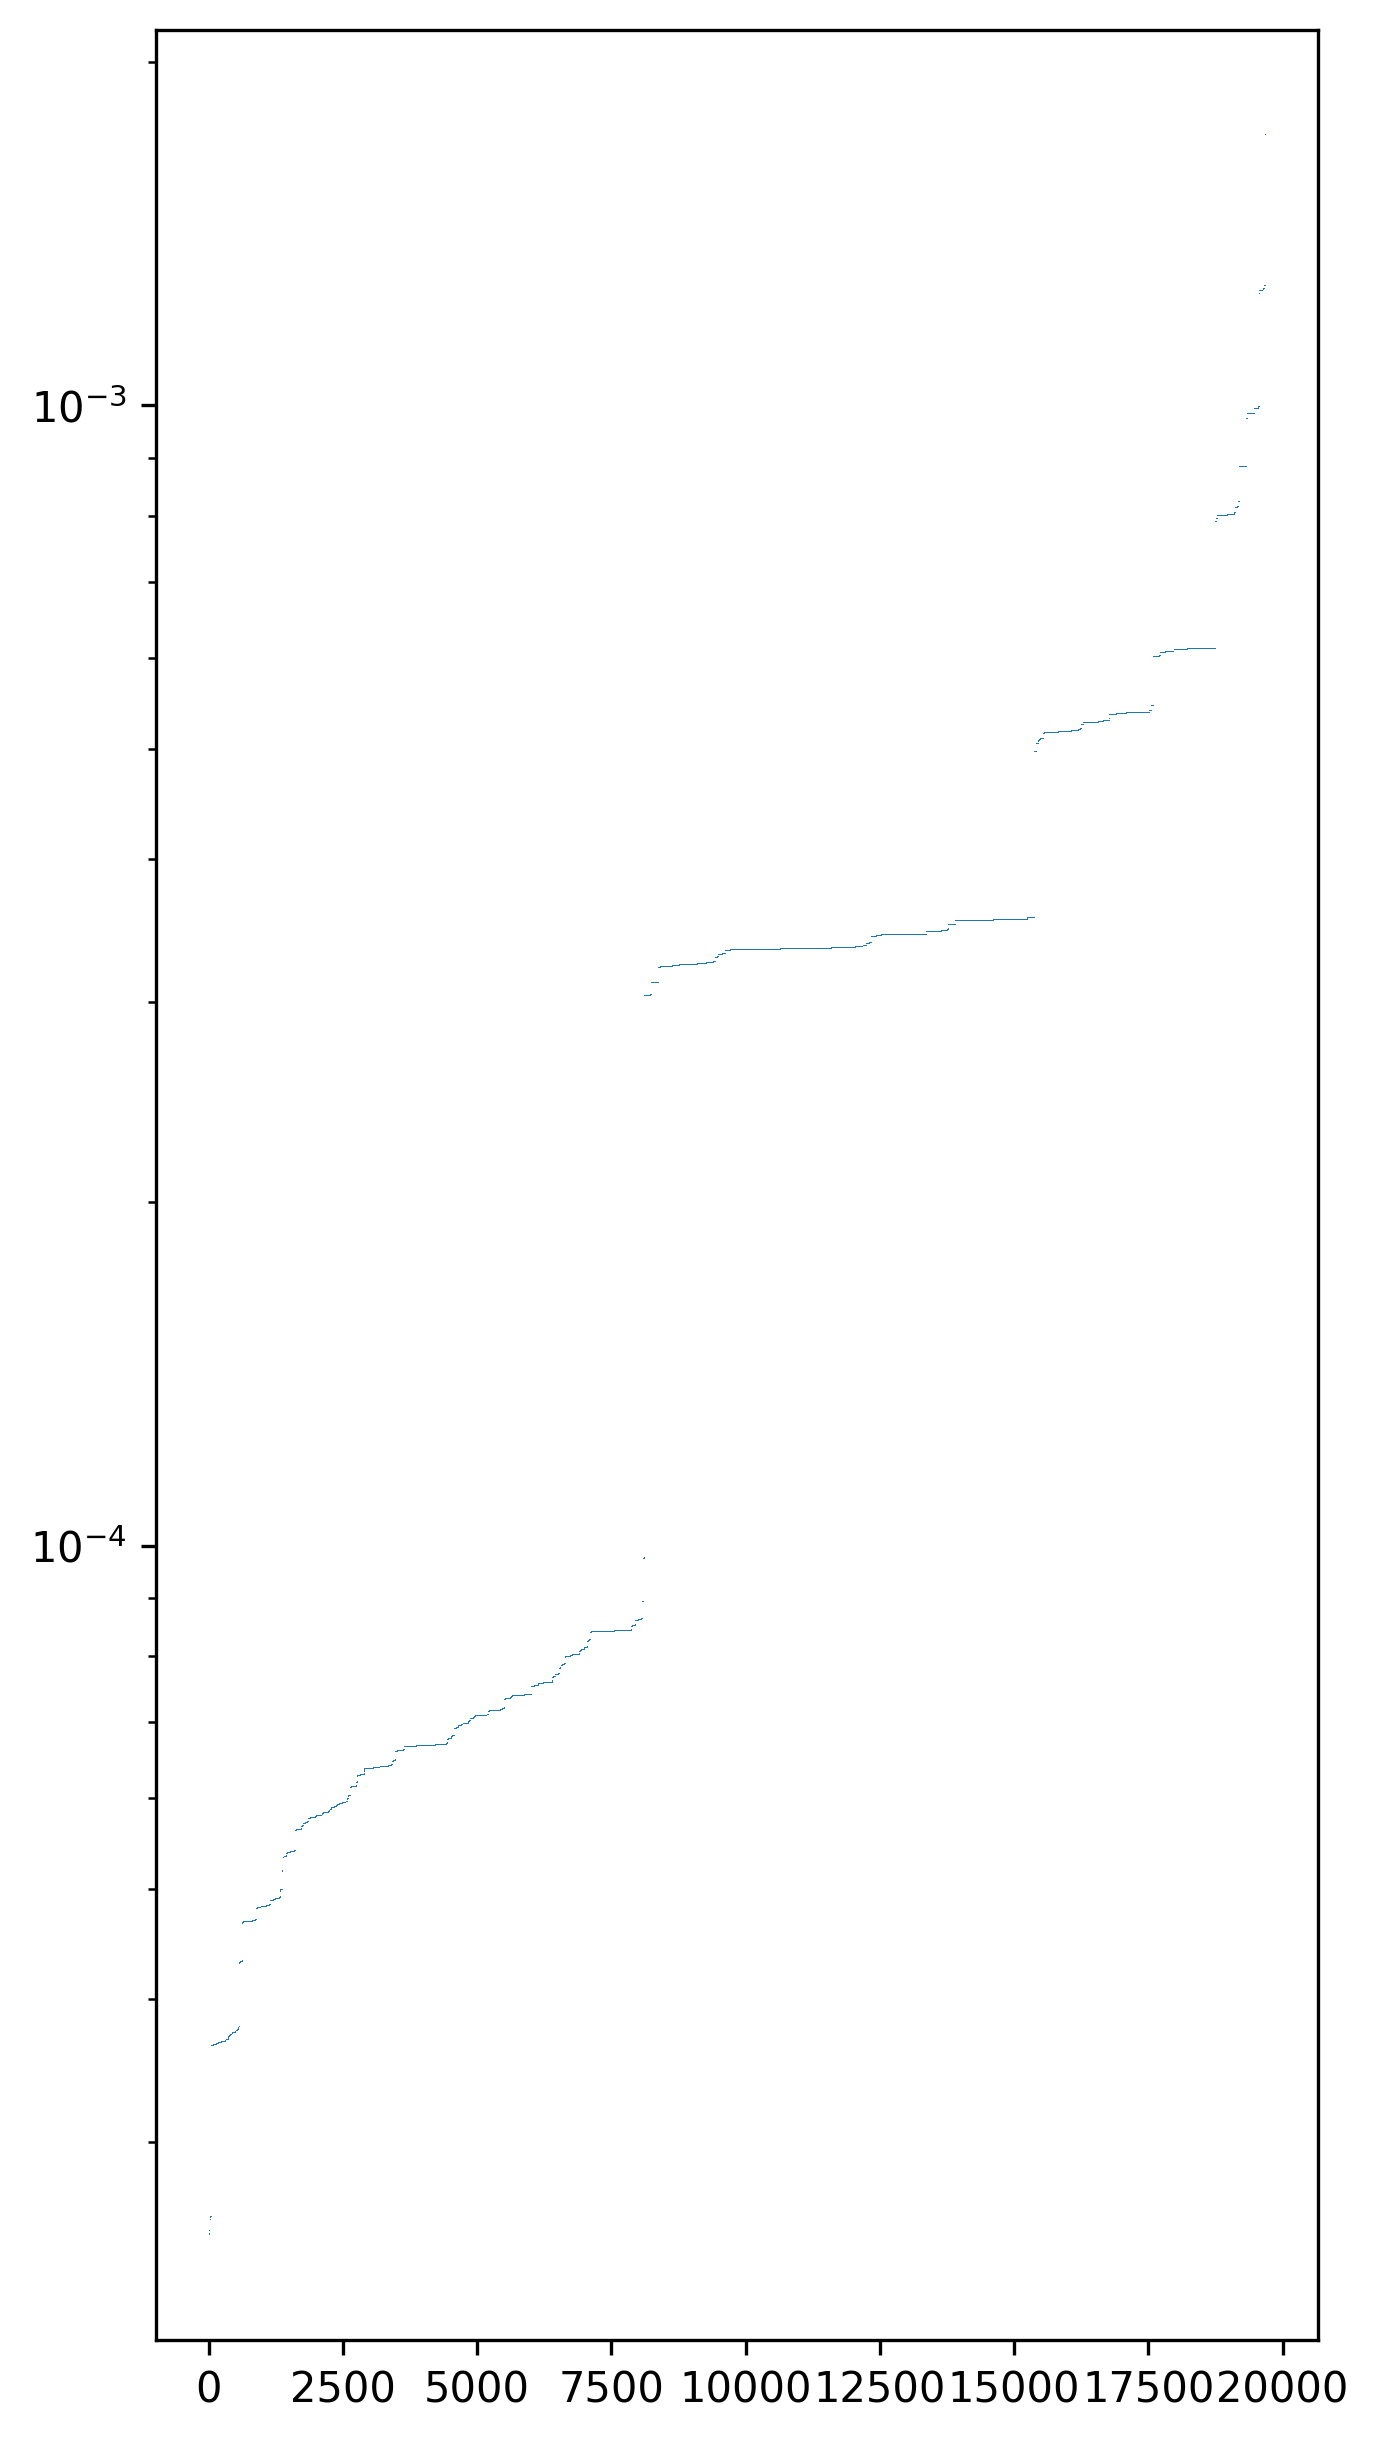

In [17]:
plt.figure(dpi=300, figsize=(5,10))
plt.plot(all_logical_error_rates.sort(), ',')
plt.yscale('log')
plt.show()